# Network Intrusion Detection with Machine Learning

## Introduction


Cyber attacks are becoming increasly varied and sophisticated with the growing use of Internet and IoT devices. This trend undermines the effectiveness of traditional rule/signature-based IDS (intrusion detection systems). The question is: can we make the IDS smart enough to identify attacks that were never seen before?

This document addresses this quesion by demonstrating a prototype workflow. It is organized as follows:

First, capture network traffic packets and transform them into high-level data sheets with fact labels. Sencond, train the labeled data (UNSW-NB15) on machine learning models such as decision trees and neural network. Third, evaluate the validility of machine learning IDS application by predicting unknown attacks. Fourth, argue about future steps (e.g. use LSTM layer) and potential use cases (e.g. IoT network, Hyperledger network).

## Network Data Preparation

We need network traffic data to represent network activities. Using well-formatted data, we can do the following 1) feed a large set of labeled network data to train machine learning models, and 2) give a pre-trained machine learning model an arbitrary number of unlabeled records to identify possible intrusions.

### Data Format

The base solution is to capture pcap files by listening on specified interfaces. For example, to capture the network activties on eth0 and save to test.pcap file, execute command: `tcpdump -i eth0 -w test.pcap`

A pcap file has a global header containing some global information followed by zero or more records for each captured packet, looking like this:

| Global Header | Packet Header | Packet Data | Packet Header | Packet Data | Packet Header | Packet Data | ... |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| AAA | BBB | CCC | DDD | EEE | FFF | GGG | ... |
| ... | ... | ... | ... | ... | ... | ... | ... |

Pcap file is the de-facto raw format for network activity recording. This format is very simple, one of the reasons that it has gained such a wide usage. However, it does not provide high-level analysis abilities.

Many tools provide customizable analysis abilities by reading and translating network traffic files in various formats (including pcap). For example, Argus and Bro.

- **Argus** (the Audit Record Generation and Utilization System) is an open source layer 2+ auditing tool (including IP audit).
- **Bro** is a passive, open-source network traffic analyzer. It is primarily a security monitor that inspects all traffic on a link in depth for signs of suspicious activity.

Let's transform the collected raw pcap file.
    
For Argus: `argus -r test.pcap -w - | ra -s +1dur +tcprtt`

| StartTime | Dur | Flgs | Proto | SrcAddr | Sport | Dir | DstAddr | Dport | TotPkts | TotBytes | State | TcpRtt |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... |
 
For Bro, the default is even more comprehensive: `bro -r test.pcap`

|	ts | uid | id.orig_h |	id.orig_p	| id.resp_h	| id.resp_p	| proto |	service |	duration |	orig_bytes |	resp_bytes |	conn_state |	local_orig |	local_resp |	missed_bytes |	history |	orig_pkts |	... |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... | ... |

On the one hand, for the purpose of training machine learning models, we need a large dataset containg labeled (Normal/Intrusion/etc.) network traffic data in high-level format similar to the output of the above libraries.

On the other hand, to predict the property of a specific network event, we need to represent this event to the same data format that was used for machine learning first, then feed it to the pre-trained model to see results.

### The UNSW_NB15 dataset

Due to the challenges of collecting, processing, and labeling a large number of network traffic data, the project will use the [UNSW-NB15](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/) dataset and focus on the analytics part.

The raw network packets of the UNSW-NB 15 dataset was created by the IXIA PerfectStorm tool in the Cyber Range Lab of the Australian Centre for Cyber Security (ACCS) for generating a hybrid of real modern normal activities and synthetic contemporary attack behaviours.

Tcpdump tool is utilised to capture 100 GB of the raw traffic (e.g., Pcap files). This dataset has nine types of attacks, namely, Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode and Worms. The Argus, Bro-IDS tools are used and twelve algorithms are developed to generate totally 49 features with the class label.

![Figure 2: The method of feature creation](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/img/feature-creation.bmp)

The details of the UNSW-NB15 dataset are published in following the papers:

1. Moustafa, Nour, and Jill Slay. "UNSW-NB15: a comprehensive data set for network intrusion detection systems (UNSW-NB15 network data set)."Military Communications and Information Systems Conference (MilCIS), 2015. IEEE, 2015.
2. Moustafa, Nour, and Jill Slay. "The evaluation of Network Anomaly Detection Systems: Statistical analysis of the UNSW-NB15 dataset and the comparison with the KDD99 dataset." Information Security Journal: A Global Perspective (2016): 1-14.

Free use of the UNSW-NB15 dataset for academic research purposes is granted by the authors.

## Intrustion Classification with Machine Learning

This diagram shows the proposed workflow for machine learning intrusion detection system. For each step, more details are explained in the following sections.

![ml-ids-module](https://raw.githubusercontent.com/honchao-w/deep-flow-ids/master/images/ml-ids-module.png)

### Download the UNSW-NB15 dataset

In [1]:
!curl -s -O https://raw.githubusercontent.com/honchao-w/deep-flow-ids/master/data/NUSW-NB15_features.csv
!curl -s -O https://raw.githubusercontent.com/honchao-w/deep-flow-ids/master/data/UNSW_NB15_training-set.csv
!curl -s -O https://raw.githubusercontent.com/honchao-w/deep-flow-ids/master/data/UNSW_NB15_testing-set.csv
!ls

NUSW-NB15_features.csv	UNSW_NB15_testing-set.csv
sample_data		UNSW_NB15_training-set.csv


### Prepocess the data

This project uses both scikit-learn and Keras (using TensorFlow backend) to build and train machine learing models. To utilize these libraries, the raw cvs files need to be converted to numpy ndarrays, and furthermore even a tensor – a generalization of vectors and matrices which also represents n-dimensional arrays used by TensorFlow.

The preparation process takes a few steps, for example:

- Normalization: normalize numerical features using min-max scaling.
- Feature engineering: replace all outlier categorical features with a single value to reduce the dimenionality of the later one-hot encoding.
- Encode categorical values: create one-hot encodings for categorical features to preclude ordered relationships among them.
- Split dataset: 1) split it into train/test (train, test) set, and 2) split each set into features (x_train, x_test) and targets (y_train, y_test).

Some of the above steps are programmed optional, so we can investigate their impacts on the intrusion detection quality.

In [0]:
import numpy as np
import pandas as pd

class USWNB15:
  
  # UNSW-NB15 dataset locations
  unsw_nb15_trn = "UNSW_NB15_testing-set.csv"
  unsw_nb15_tst = "UNSW_NB15_training-set.csv"
  unsw_nb15_ftr = "NUSW-NB15_features.csv"
  
  # The names of numerical columns
  num_cols = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat',
       'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']
  
  # The names of categorical columns
  cat_cols = ['proto', 'service', 'state']
  
  # The names of target columns
  y_cols = ['attack_cat', 'label']
  
  # Frequent values of in each categorical features
  cat_freq_val = {
      'proto': ['tcp', 'udp', 'unas', 'arp', 'ospf', 'sctp'],
      'service': ['dns', 'http', 'smtp', 'ftp-data', 'ftp', 'ssh', 'pop3'],
      'state': ['INT', 'FIN', 'CON', 'REQ']
  }
  
  """
  Initialize dataset object
  """
  def __init__(self, raw):
    self.all = self.read_from_csv()
    
    # Reduce dimensionality if requested
    if raw:
      self.reduced = False
    else:
      self.reduce_dimension(self.all)
      self.reduced = True
    
    self.normalize(self.all)
    self.all_oh = self.one_hot(self.all)
    self.load_all()
    self.load_intrusion()
    
    print('USW-NB15 data is loaded.')
  
  """
  Load data and split it into subsets such as train/test and features/targets
  """
  def load_all(self):
    self.train = self.all_oh.loc['train']
    self.test = self.all_oh.loc['test']
    
    self.x_train, self.y_train_cat, self.y_train_lab = self.split_xy(
        self.train)
    self.x_test, self.y_test_cat, self.y_test_lab = self.split_xy(
        self.test)
  
  """
  Load only intrusion records
  """
  def load_intrusion(self):
    train_idx = np.where(self.train['label'] == 1)
    test_idx = np.where(self.test['label'] == 1)
    
    self.x_train_i, self.y_train_i = self.select_df_pair_rows(
        self.x_train, self.y_train_cat, train_idx)
    
    self.x_test_i, self.y_test_i = self.select_df_pair_rows(
        self.x_test, self.y_test_cat, test_idx)
  
  """
  Split the data into features and targets
  """
  def split_xy(self, df):
    x = df.drop(self.y_oh_cols, axis=1).values
    y_cat = df[self.y_oh_cols[:-1]].values
    y_lab = df[self.y_oh_cols[-1:]].values
    
    return x, y_cat, y_lab
  
  """
  Select specified rows for a pair of dataframe
  """
  def select_df_pair_rows(self, x, y, rows):
    return x[rows,:][0], y[rows, :][0]
    
  """
  Read data from csv file
  """
  def read_from_csv(self):
    self.ftr_df = pd.read_csv(
        self.unsw_nb15_ftr, encoding = "ISO-8859-1", index_col='No.')
    
    trn_df = pd.read_csv(self.unsw_nb15_trn, index_col='id')
    tst_df = pd.read_csv(self.unsw_nb15_tst, index_col='id')
    all_df = pd.concat([trn_df, tst_df], keys=['train', 'test'])
    return all_df
    
  """
  Simplify categorical features in preparation for one-hot encoding
  """
  def reduce_dimension(self, df):
    for attr in self.cat_cols:
      df.loc[~df[attr].isin(self.cat_freq_val[attr]), attr] = 'other'
  
  """
  normalize
  """
  def normalize(self, df):
    cols = self.num_cols
    df[cols] = df[cols].apply(
        lambda x: (x - x.mean()) / (x.max() - x.min()))
  
  """
  One-hot encoding categorical features
  """
  def one_hot(self, df):
    # one-hot encode categorical features
    df = pd.get_dummies(data=df, columns=self.cat_cols)
    
    # one-hot encode the attack_cat label; leave binary label as is
    df = pd.get_dummies(data=df, columns=['attack_cat'])
    
    # move label column to the end
    cols = df.columns.tolist()
    cols = [col for col in df if col != 'label'] + ['label']
    df = df[cols]
    
    # target column names for one-hot encoded dataset  
    self.y_oh_cols = [
        col for col in df if col.startswith('attack_cat')
    ] + ['label']
    
    # feature column names for one-hot encoded dataset
    self.x_oh_cols = [col for col in df if col not in self.y_oh_cols]
    
    return df
  
  """
  statistics
  """
  def stat(self):
    # to do
    print("Total number of records: ", len(self.x_train))

### Explore the data

In [5]:
data = USWNB15(True)

USW-NB15 data is loaded.


These features are described in UNSW-NB15_features.csv file. Let's see the first 3 rows:

In [6]:
data.ftr_df.head(3)

,Name,Type,Description
No.,,,
1,srcip,nominal,Source IP address
2,sport,integer,Source port number
3,dstip,nominal,Destination IP address


The ground truth table is named UNSW-NB15_GT.csv and the list of event file is called UNSW-NB15_LIST_EVENTS.csv.

A partition from this dataset is configured as a training set and testing set, namely, UNSW_NB15_training-set.csv and UNSW_NB15_testing-set.csv respectively.

The number of records in the training set is 175,341 records and the testing set is 82,332 records from the different types, attack and normal.Figure 1 and 2 show the testbed configuration dataset and the method of the feature creation of the UNSW-NB15, respectively.

Let's see the first 3 rows of the one-hot encoded training data:

In [7]:
data.train.head(3)

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,attack_cat_Backdoor,attack_cat_DoS,attack_cat_Exploits,attack_cat_Fuzzers,attack_cat_Generic,attack_cat_Normal,attack_cat_Reconnaissance,attack_cat_Shellcode,attack_cat_Worms,label
id,,,,,,,,,,,,,,,,,,,,,
1,-0.018754,-0.001294,-0.001317,-0.000579,-0.000970,-0.091180,0.282349,0.666319,-0.011789,-0.028976,...,0,0,0,0,0,1,0,0,0,0
2,-0.009947,-0.000543,0.001768,-0.000546,0.001885,-0.091175,-0.462749,0.658445,-0.011790,-0.006897,...,0,0,0,0,0,1,0,0,0,0
3,0.006274,-0.001106,-0.000228,-0.000572,-0.000082,-0.091240,-0.462749,0.658445,-0.011791,-0.026637,...,0,0,0,0,0,1,0,0,0,0


### Build the model

Essentially, the task of intrusion detection is a classification task in the context of machine learing.  It can be further divided into two cases: 1) **binary classification**, if the IDS only needs to assert whether a given event is an attack or not; and 2) **multiclass classification**, if the IDS needs to report the exact category if there is an intrusion detected. We might have different expectations and evaluation metrics for these two different cases. And in fact, it is also an important factor to consider when deciding which machine learing model to deploy at which stages.

For the purpose of experiment, I implemented machine learning workflows for label classification (binary) and category classfication (multiclass) using both decision trees and neural networks:

- **Decision trees**: used an extra-trees classifier; this class implements a meta estimator that fits a number of randomized decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.
- **Feedforward neural network**: neural network is composed of a large number of highly interconnected processing elements working in unison to solve specific problems; like people, it learns by example.

In [0]:
from tensorflow import keras

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier

class MachineLearning:
  
  def __init__(self, data):
    self.d = data
  
  """
  Neural network for label classification
  """
  def neural_network(self):
    
    if self.d.reduced:
      model = keras.Sequential([
          keras.layers.Dense(32, activation='relu'),
          keras.layers.Dense(1, activation='sigmoid')
      ])
    else:
      model = keras.Sequential([
          keras.layers.Dense(128, activation='relu'),
          keras.layers.Dense(32, activation='relu'),
          keras.layers.Dense(16, activation='relu'),
          keras.layers.Dense(1, activation='sigmoid')
      ])

    model.compile(optimizer='adam',
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])
    
    x_train, y_train, x_test, y_test = self.data_for_lab()
    
    rand_idx = [i for i in random.sample(range(len(x_test)),
                                         int(len(x_test) / 10))]
    
    self.nn_history = model.fit(x_train,
                                y_train,
                                shuffle=True,
                                batch_size=64,
                                #validation_split=0.1,
                                validation_data=(x_test[rand_idx, :],
                                                 y_test[rand_idx, :]),
                                epochs=6)
    
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('Test accuracy:', test_acc)
    
    self.nn_model = model
  
  """
  Neural network for category classification
  
  :param bool intrusion_only: train model on only instruion data
  """
  def neural_network_cat(self, intrusion_only):
    
    if self.d.reduced:
      model = keras.Sequential([
          keras.layers.Dense(64, activation='relu'),
          keras.layers.Dense(32, activation='relu'),
          keras.layers.Dense(10, activation='softmax')
      ])
    else:
      model = keras.Sequential([
          keras.layers.Dense(128, activation='relu'),
          #keras.layers.Dropout(.6),
          keras.layers.Dense(64, activation='relu'),
          #keras.layers.Dropout(.6),
          keras.layers.Dense(32, activation='relu'),
          keras.layers.Dense(10, activation='softmax')
      ])
  
    model.compile(optimizer='adam',
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy', self.top2_accuracy])
    
    x_train, y_train, x_test, y_test = self.data_for_cat(intrusion_only)
    
    rand_idx = [i for i in random.sample(range(len(x_test)),
                                         int(len(x_test) / 10))]
    
    self.nn_cat_history = model.fit(x_train,
                                    y_train,
                                    # validation_split=0.1,
                                    validation_data=(x_test[rand_idx, :],
                                                     y_test[rand_idx, :]),
                                    epochs=5)
    
    test_loss, test_acc, test_acc2 = model.evaluate(x_test, y_test)
    print('Test accuracy:', "top 1", test_acc, "top 2", test_acc2)
    
    self.nn_cat_model = model
    
  """
  Decision trees for label classification
  """
  def decision_trees(self):
    x_train, y_train, x_test, y_test = self.data_for_lab()
    
    model = ExtraTreesClassifier().fit(x_train,y_train.ravel())
    print("Test accuracy: ", model.score(x_test, y_test.ravel()))
    self.forest_model = model
  
  """
  Decision trees for category classification
  
  :param bool intrusion_only: train model on only instruion data
  """
  def decision_trees_cat(self, intrusion_only):
    x_train, y_train, x_test, y_test = self.data_for_cat(intrusion_only)
    
    model = ExtraTreesClassifier().fit(x_train, y_train.ravel())
    print("Test accuracy: ", model.score(x_test, y_test.ravel()))
    
    self.forest_cat_model = model
  
  """
  Data preparation for label classification
  """
  def data_for_lab(self):
    x_train, y_train = self.d.x_train, self.d.y_train_lab
    x_test, y_test = self.d.x_test, self.d.y_test_lab
    
    return x_train, y_train, x_test, y_test
  
  """
  Data preparation for category classification
  """
  def data_for_cat(self, intrusion_only):
    if intrusion_only:
      x_train, y_train = self.d.x_train_i, self.d.y_train_i
      x_test, y_test = self.d.x_test_i, self.d.y_test_i
    else:
      x_train, y_train = self.d.x_train, self.d.y_train_cat
      x_test, y_test = self.d.x_test, self.d.y_test_cat
    
    return x_train, y_train, x_test, y_test

  """
  If the expected target is within the top 3 predications
  """
  def top2_accuracy(self, y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)
  
  """
  Get the model's confusion matrix using test data
  
  :param ExtraTreesClassifier/keras.Sequential model: trained model
  """
  def cnf_matrix(self, model):
    x_test = self.d.x_test
    y_test = self.d.y_test_lab

    predictions = model.predict(x_test)
    cm = confusion_matrix(y_test, predictions)
    return cm

ml = MachineLearning(data)

### Model analysis

Visualize and analyze the performance of machine learning models.

In [0]:
!apt-get install graphviz > /dev/null
!pip -q install graphviz
!pip -q install pydot

In [0]:
import graphviz
import random
import itertools
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from IPython.display import SVG

class ModelVisualizer:
  x_names = data.x_oh_cols
  
  def neural_network(self, model):
    model.summary()
    SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
  
  def neural_network_training(self, history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'], 'b', label='Training acc')
    plt.plot(history.history['val_acc'], 'g', label='Validation acc')
    plt.title('Traing accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
  
  def decision_trees_lab(self, forest):
    classes = self.get_class_names(True)
    self.decision_trees(forest, classes)
    
  def decision_trees_cat(self, forest, intrusion_only):
    classes = self.get_class_names(False)
    if intrusion_only:
      classes.remove('Normal')
    self.decision_trees(forest, classes)
  
  def decision_trees(self, forest, classes):
    self.decision_tree_graph(random.choice(forest.estimators_), classes)
    self.decision_trees_feature_importance(forest, classes)
    
  
  def decision_tree_graph(self, dt, classes):
    dot_data = export_graphviz(dt, out_file=None,
                               max_depth=3,
                               feature_names=self.x_names,
                               class_names=classes,
                               filled=True,
                               proportion=True,
                               rounded=True)
    self.dt_graph = graphviz.Source(dot_data)
  
  def decision_trees_feature_importance(self, forest, classes):
    top_k = 20
    
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    indices = indices[:top_k]

    # print("Feature ranking:")
    # for f in range(top_k):
    #    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(top_k), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(top_k), indices)
    plt.xlim([-1, top_k])
    plt.show()
  
  def cnf_matrix_lab(self, model):
    classes = self.get_class_names(True)
    
    x_test, y_test = data.x_test, data.y_test_lab
    
    predictions = model.predict(x_test)
    cm = confusion_matrix(y_test, predictions)
    
    self.cnf_matrix(cm, classes)
    
  def cnf_matrix_cat(self, model, intrusion_only):
    classes = self.get_class_names(False)
    
    if intrusion_only:
      x_test, y_test = data.x_test_i, data.y_test_i
      classes.remove('Normal')
    else:
      x_test, y_test = data.x_test_cat, data.y_test.cat
    
    predictions = model.predict(x_test)
    
    cm = confusion_matrix(
        [np.argmax(y) for y in y_test],
        [np.argmax(pred) for pred in predictions]
    )
    
    self.cnf_matrix(cm, classes)
  
  def cnf_matrix(self, cm, classes):
    #print('Confusion matrix:\n', cm)
    plt.rcParams["figure.figsize"] = (8, 6)
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
  
  def predictions_vs_exp(self, model, x_test, y_test):
    predictions = model.predict(x_test)
    rand_idx = [i for i in random.sample(range(len(predictions)), 20)]
    
    for i in rand_idx:
      print(np.argmax(predictions[i]), np.argmax(y_test[i]))
  
  def get_class_names(self, label_task):
    if label_task:
      return ['Normal', 'Intrusion']
    else:
      return ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers',
              'Generic','Normal','Reconnaissance','Shellcode','Worms']
  
viz = ModelVisualizer()

### Train and evaluate the model

For demo purpose, this section follows the recommended workflow, that is using extra-trees for label classification, then using neural networks for category classficaiton. You can try other combinations with the provided APIs.

For binary label classification task, the decision trees yield a accuracy of 87%:

In [13]:
ml.decision_trees()

Test accuracy:  0.8702205703736093


Important features found by decision trees to judge whether a network event is an intrusion or not:

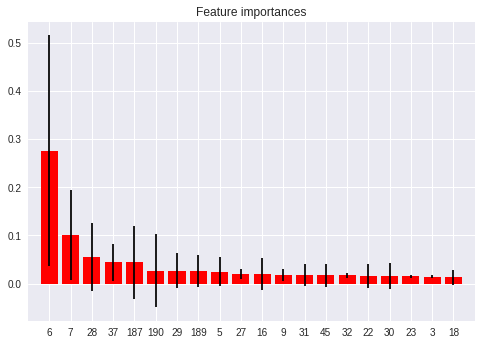

In [16]:
viz.decision_trees_lab(ml.forest_model)

The visualization of a random one of the decision trees generated by the extra-trees classifier. It shows the exactly how an decision tree judge an intrusion. Extra-tree classifier, however, is an aggregation of such trees and consider all their results to make a final classification decision.

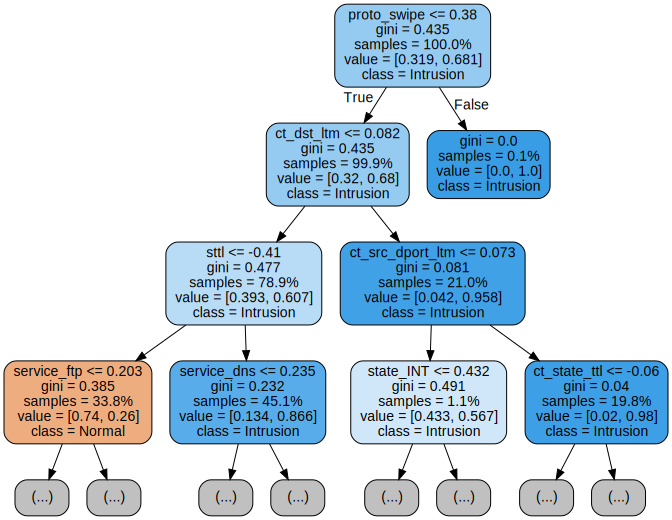

In [22]:
viz.dt_graph

For binary classification, even random guessing can reach 50%+ accuracy. Therefore, a confusion matrix is essential to help us evaluate how model quality. For example, the following diagram is the confusion matrix of the trained extra-tress model.

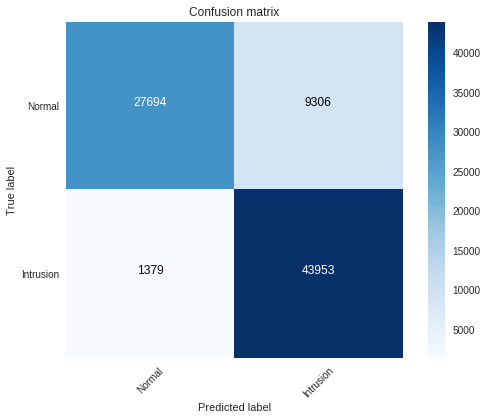

In [23]:
viz.cnf_matrix_lab(ml.forest_model)

It shows for intrusion detection, the **TP** (true positive) 43953, **FP** (false positive) is 9306, **FN** (false negative) is 1379, and **TN** (true negtive) is 27694. From there, we get  **Precision** = TP/(TP+FP) = 0.75, meaning out of all the classes, how much we predicted correctly; **Recall** = TP/(TP+FN) = 0.95, meaning out of all the positive classes, how much we predicted correctly; and the **F1-score** = 2 x Recall x Precision / (Recall + Precision), which is a metrics used to compare two different models.

| Class | Precision | Recall | F1-score |
| --- | --- | --- | --- |
| Normal | 0.75 | 0.95 | 0.83 |
| Intrusion | 0.83 | 0.97 | 0.89 |

For category classification, a feedforward neural network with four fully-connected layers is built to train intrusion records only.

The top2_accuracy is intoduced to evalute the model in addition to accuracy because once an intrusion has been correctly identified, categorizing it is not as crucial and a little less precision can be tolerated. Here, category classification serves as an auxilliary tool to analyze intrusion quicker. It is reasonable to say if a model can predict the top 2 possible attack types most of the time, then it is useful.

As we can see, the top2_accuracy (0.90) is much higher than accuracy (0.78). In real-world use case, both top 2 predictions can give valuable suggestions.

In [28]:
ml.neural_network_cat(True)

Train on 119341 samples, validate on 4533 samples
Epoch 1/5
119341/119341 [==============================] - 7s 61us/step - loss: 0.6976 - acc: 0.7474 - top2_accuracy: 0.8971 - val_loss: 0.6351 - val_acc: 0.7741 - val_top2_accuracy: 0.8882
Epoch 2/5
119341/119341 [==============================] - 7s 55us/step - loss: 0.6249 - acc: 0.7687 - top2_accuracy: 0.9115 - val_loss: 0.6066 - val_acc: 0.7827 - val_top2_accuracy: 0.8983
Epoch 3/5
119341/119341 [==============================] - 7s 56us/step - loss: 0.6022 - acc: 0.7757 - top2_accuracy: 0.9147 - val_loss: 0.5954 - val_acc: 0.7913 - val_top2_accuracy: 0.8998
Epoch 4/5
119341/119341 [==============================] - 7s 57us/step - loss: 0.5864 - acc: 0.7815 - top2_accuracy: 0.9174 - val_loss: 0.6163 - val_acc: 0.7834 - val_top2_accuracy: 0.8970
Epoch 5/5
45332/45332 [==============================] - 1s 26us/step
Test accuracy: top 1 0.7792067413852651 top 2 0.9013500397017908


To see the architecture of the neural network model:

In [29]:
ml.nn_cat_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              multiple                  25216     
_________________________________________________________________
dense_9 (Dense)              multiple                  8256      
_________________________________________________________________
dense_10 (Dense)             multiple                  2080      
_________________________________________________________________
dense_11 (Dense)             multiple                  330       
Total params: 35,882
Trainable params: 35,882
Non-trainable params: 0
_________________________________________________________________


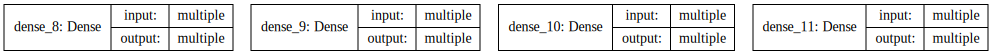

In [30]:
SVG(model_to_dot(ml.nn_cat_model, show_shapes=True).create(prog='dot', format='svg'))

The training history shows that the training accuracy and test accuracy are gradually increasing together during epochs. However, at one point and test accuracy will start to decline, which might be the side effect of model's over-fitting. Now it is better stop training.

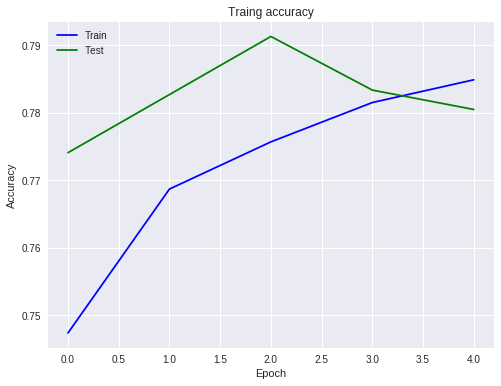

In [31]:
viz.neural_network_training(ml.nn_cat_history)

The following confusion matrix for category classification also provides intersting insights on how effective the model is.

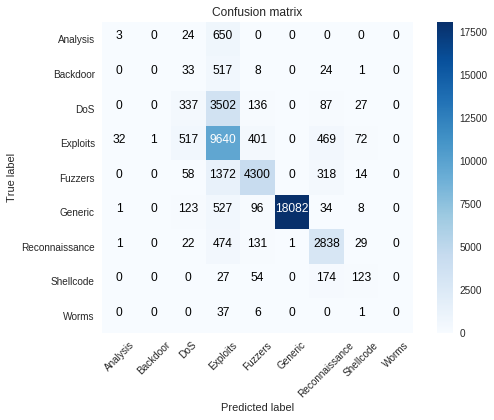

In [32]:
viz.cnf_matrix_cat(ml.nn_cat_model, True)

## Future steps

### The case for IoT security

Like any traditional servers or desktops, IoT devices can deploy IDS for better protection. Some notable differences are: 1) IoT devices have limited computational capabilities, 2) IoT devices have relatively simpler system setups but with much more variety, 3) IoT devices can have a large scale in any network, etc.

A possible deployment could be: IoT devices collect their own network traffic and convert to a preset format to feed to the label classification model. If an intrusion is predicted, the record is passed to category classification model, get top 2 possible attack types, and notify the admin. If a serious kind of attack is among the 2 attack types, the IoT device will disconnect it from the network immediately.

![IoT setup](https://raw.githubusercontent.com/honchao-w/deep-flow-ids/master/images/IoT-setup.png)

### The case for Hyperledger Fabric security

Hyperledger Fabric is a blockchain network with its own protocal, topology, and architecute, etc. Like pcap, if we are able to represent a Hyperledger event in a tabular form, such as:

| feature 1 | feature 2 | feature 3 | ... | feature n | target 1 | target 2 | ... | target n |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| AAA | BBB | CCC | ... | DDD | EEE | FFF | ... | GGG |

If this is possible, then most likely, we can train a specialized machine learning Intrusion detection model for Hyperledger.

### The case for RNN (Recurrent Neural Network)

In the above design, I used fully-connected dense layers in the neural network model because it was the sensible choice to make considering the given data format.

The way current data is formatted comes from a high-level analysis on raw pcap files powered by third-party libraries. I propose it is possible to train the captured pcap files directly by introducing RNN layers (e.g. LSTM) in the neural network.

The assumption is that pcap file is a sequence of activties, and the order of each record provides important context in terms of intrusion detection. To be able to feed data to the RNN, the data should be prepared in this format:

- x_train.shape = (samples, timesteps, features)
- y_train.shape = (sameples, classes)

Again, the challege lies in getting hold of such labeled dataset in large volume.

## Reference

- Moustafa, Nour, and Jill Slay. "UNSW-NB15: a comprehensive data set for network intrusion detection systems (UNSW-NB15 network data set)." Military Communications and Information Systems Conference (MilCIS), 2015. IEEE, 2015. 
- Chollet, François. "Keras." (2015).